## Семинар 2 "Распознавание рукописных цифр"

ФИО : Яковлев Дмитрий Алексеевич

Прошу прощение за задержку. Из-за вдруг возникших проблем с зубами и очень сильной вследствие этого болью, не смог выполнить и отправить вам задания до дедлайна. Прошу войти в положение, если это конечно возможно. Впредь буду стараться отправлять задания вовремя. Надеюсь на ваше понимание.


В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
cd 'gdrive/My Drive/notebooks/NN/hw2'

/content/gdrive/My Drive/notebooks/NN/hw2


In [3]:
! ls

'[DZNN_IMSH_2023] DZ2_yakovlevda.ipynb'   layers.py   MNIST   __pycache__


In [4]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import numpy as np
import sys

from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork
from IPython.display import clear_output
%matplotlib inline

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [7]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

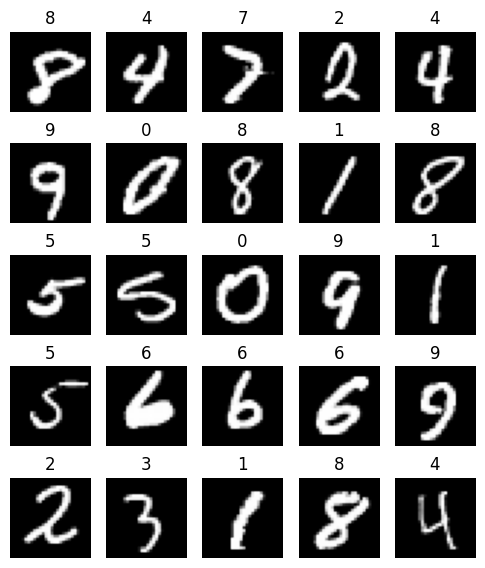

In [8]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [9]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))

            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))

            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')

                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [10]:
network_s = NeuralNetwork([
    Linear(784, 100), Sigmoid(),
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.298/0.293	Accuracy: 0.921/0.920

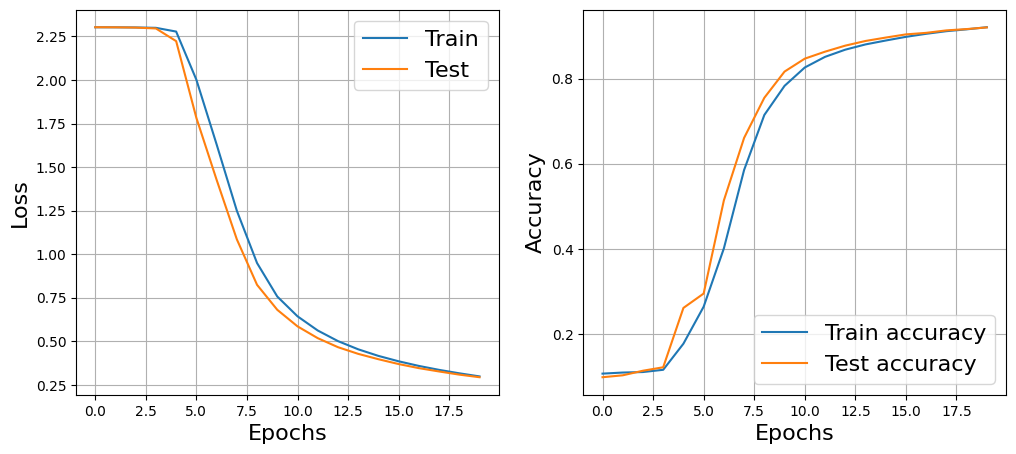

In [11]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network_s, 20, 0.01, loss=loss)

### Часть 2: Нелинейности

#### ReLU и ELU

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

Справка:<br>
$ReLU$ - Rectified Linear Unit<br>
$
\begin{aligned}
& ReLU(x) = \begin{cases}
& x & \quad \text{$ x \geq 0 $}\\ 
& 0 & \quad \text{$ x < 0 $}
& \end{cases}\Longleftrightarrow \quad x = max(x, 0)
\end{aligned}
$
<br>
<br>
$ELU$ - Exponential Linear Unit<br>
$
\begin{aligned}
& ELU(x) = \begin{cases}
& x & \quad \text{$ x \geq 0 $}\\ 
& \alpha(e^{x}-1)  & \quad \text{$ x < 0 $}
& \end{cases}\Longleftrightarrow \quad x = max(x, 0)
\end{aligned}
$

In [12]:
class ReLU:
    def __init__(self):
        pass


    def forward(self, X):
        self.X = X
        return np.maximum(self.X, 0)


    def backward(self, dLdy):
        return (self.X > 0) * dLdy


    def step(self, learning_rate):
        pass

In [13]:
class ELU:
    def __init__(self, a=1.0):
        self.a = a


    def forward(self, X):
        self.X = X
        return (
            self.X * (self.X >= 0) + 
            self.a * (np.exp(self.X) - 1) * (self.X < 0)
        )


    def backward(self, dLdy):
        return dLdy * (
            (self.X >= 0) + 
            (self.a * np.exp(self.X)) * (self.X < 0)
        )


    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.038/0.085	Accuracy: 0.989/0.975

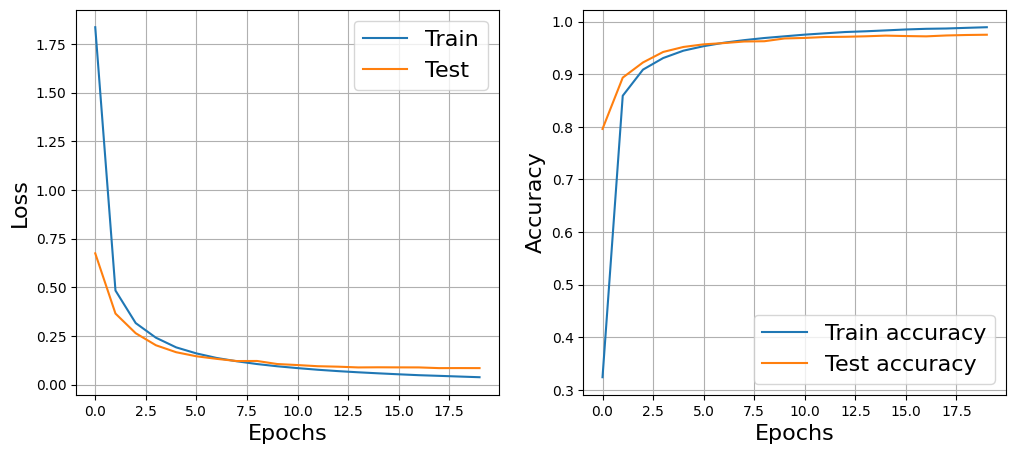

In [14]:
network_r = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])

loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network_r, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.045/0.078	Accuracy: 0.988/0.974

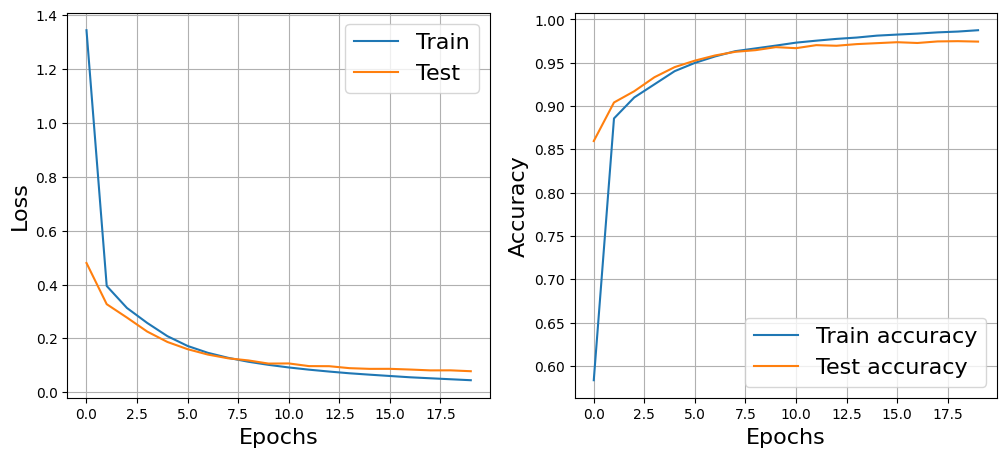

In [15]:
network_e = NeuralNetwork([
    Linear(784, 100), ELU(),
    Linear(100, 100), ELU(),
    Linear(100, 10)
])

loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network_e, 20, 0.01, plot=True, verbose=True)

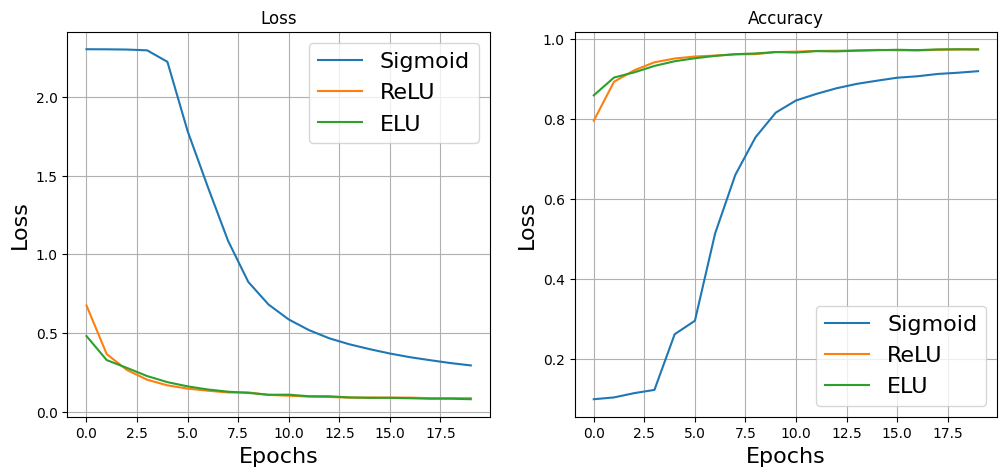

In [16]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.show()

### HW1 (1 балл): Реализовать Tanh

$Tanh$ - Hyperbolic Tangent<br>
$
\begin{aligned}
& \frac{d}{dx}[Tanh(x)] = 1 - Tanh(x)^2
\end{aligned}
$

In [17]:
class Tanh:
    def __init__(self):
        pass


    def forward(self, X):
        self.tanh = np.tanh(X)
        return self.tanh

    
    def backward(self, dLdy):
        return dLdy * ( 1 - np.square(self.tanh) )

    
    def step(self, learning_rate):
        pass

Проведём такой-же пайплайн, как с предыдущими нелинейностями.<br>
Сравним результаты нелинейностей : $σ$, $ReLU$, $ELU$, $Tanh$. 

Epoch 19... (Train/Test) NLL: 0.030/0.077	Accuracy: 0.994/0.975

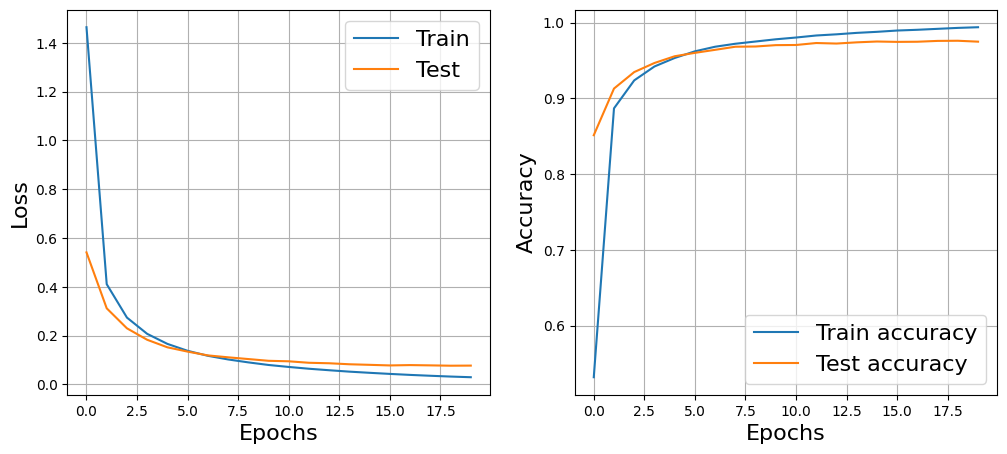

In [18]:
network_t = NeuralNetwork([
    Linear(784, 100), Tanh(),
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])

loss = NLLLoss()
tr_t, ts_t, tr_ac_t, ts_ac_t = train(network_t, 20, 0.01, plot=True, verbose=True)

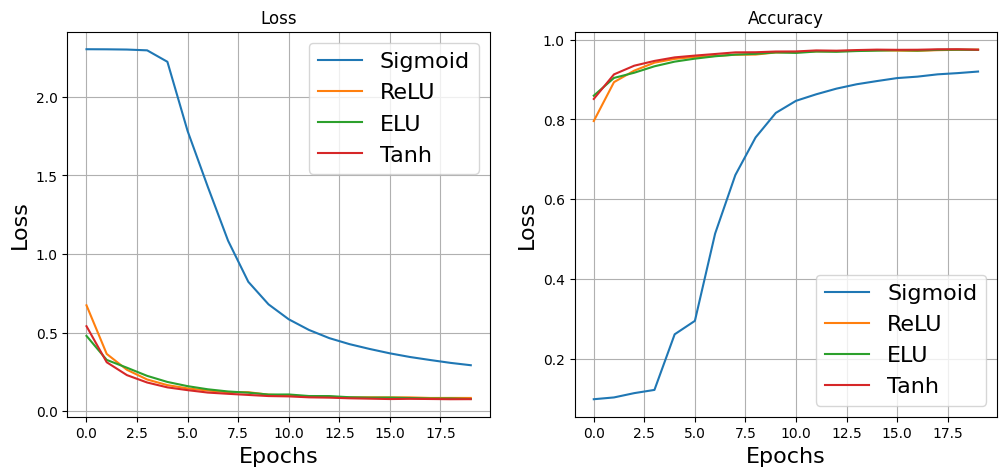

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.show()

#### Выводы по нелинейностям
Топ по скорости сходимости в разрезе эпох:
1. $ELU$ - 12 минут
2. $Tanh$ - 11 минут
3. $ReLu$ - 11 минут
4. $Sigmoid$ - 12 минут
<br>

Исходя из скорости сходимости по эпохам и времени обучения, наилучшей нелинейностью будет $ReLU$.

### Часть 3: Анализ ошибок

Давайте предложенный код в тетрадке обернём в функцию от модели.<br>
Узнаем как разные функции активации влияют на характер ошибок при всех прочих равных условиях.

In [27]:
def missmatch_analysis(network):
    wrong_X = []
    correct_y = []
    predicted_y = []
    logits = []

    for X, y in test_loader:
        X = X.view(X.shape[0], -1).numpy()
        y = y.numpy()
        
        prediction = network.forward(X)
        prediction = np.exp(prediction)
        prediction /= prediction.sum(1, keepdims=True)
        for i in range(len(prediction)):
            if np.argmax(prediction[i]) != y[i]:
                wrong_X.append(X[i])
                correct_y.append(y[i])
                predicted_y.append(np.argmax(prediction[i]))
                logits.append(prediction[i][y[i]])

    wrong_X = np.row_stack(wrong_X)
    correct_y = np.row_stack(correct_y)[:, 0]
    predicted_y = np.row_stack(predicted_y)[:, 0]
    logits = np.row_stack(logits)[:, 0]

    plt.figure(figsize=(10, 5))
    order = np.argsort(logits)

    for i in range(21):
        plt.subplot(3, 7, i+1)
        plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
        plt.axis('off')

Вызывем функцию для сети с нелинейностью:
* Сигмоида
* ReLU
* ELU
* Tanh

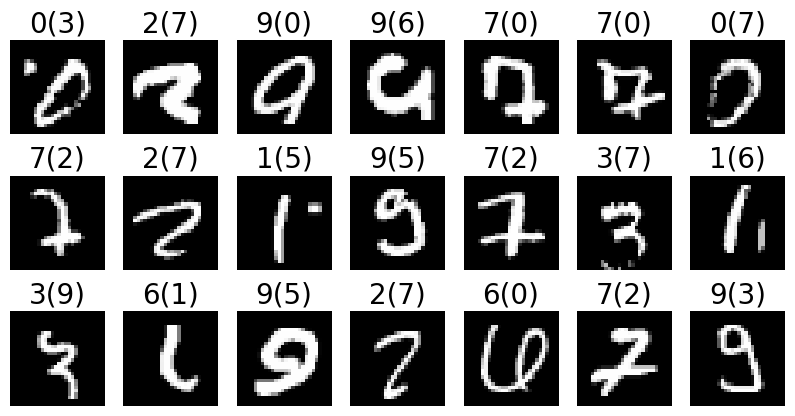

In [28]:
missmatch_analysis(network_s)

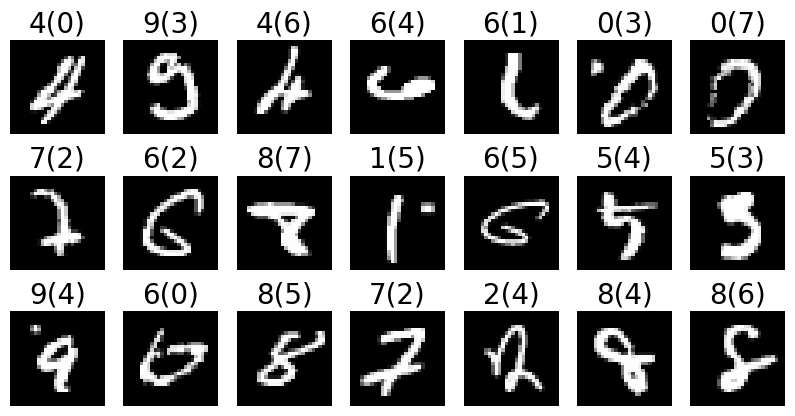

In [29]:
missmatch_analysis(network_r)

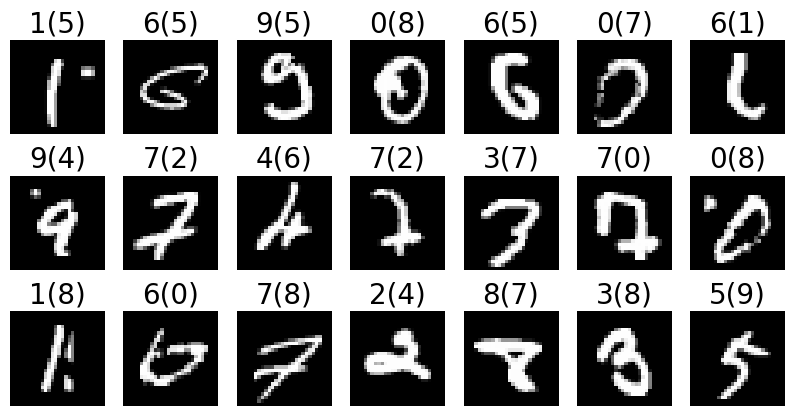

In [30]:
missmatch_analysis(network_e)

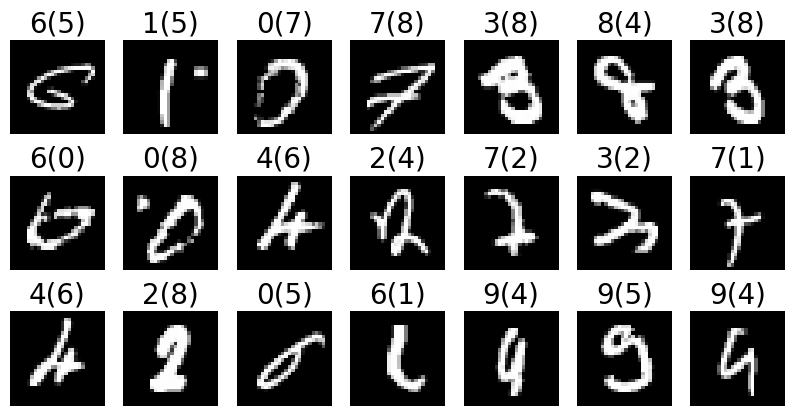

In [31]:
missmatch_analysis(network_t)

#### Выводы по ошибкам

Исходя из того что результаты приведены в порядке наибольшей ошибки модели к наименьшей, первые 21 ошибки могут дать некоторое представление о качестве определённой модели.

1. Сеть с сигмоидой путает:
    * 0 - 3, 7 (лишний мазок, плохая связность эллипса)
    * 1 - 5, 6 (лишний мазок)
    * 2 - 7 
    * 3 - 7, 9 (недорисованность нижней части, лишняя завитушка)
    * 4 - None
    * 5 - None
    * 6 - 0, 1 (поворот на -90°, недорисованность овала нижней части)
    * 7 - 2
    * 8 - None
    * 9 - 0, 5, 3 (отсутсвие выраженной нижней дуги для случая с 0)
2. Сеть с ReLU путает:
    * 0 - также как и с сигмоидой
    * 1 - в отличие от сигмоиды ошибка с 6 не в первых 21 ошибках(возможно и вовсе не ошиблась) в остальном также как сеть сигмоидой если судить визуально
    * 2 - 4 (лишняя завитушка наверху)
    * 3 - None
    * 4 - 0, 6 (вытянуто вверх, вытянуто вниз)
    * 5 - 4, 3 (слабо выраженная верхняя черта, верхняя черта слилась)
    * 6 - 4, 1, 2, 5, 0 (все имеют проблемы со связностью)
    * 7 - 2, 0, 8 (лишние завитушки, вытянутость или толщина)
    * 8 - 7, 5, 6 (сплюснутость, связность)
    * 9 - 5 (связность)
3. Сеть с ELU путает:
    * 0 - 8, 7 (лишний мазок, связность)
    * 1 - 5, 8 (лишний мазок) появилась ошибка с 8
    * 2 - None
    * 3 - 7, 8 (потеря формы, толщина)
    * 4 - 6 как и в предыдущих
    * 5 - 9 (возможно наклон на 30° по часовой)
    * 6 - 5 (связность, завершенность паттерна)
    * 7 - 2, 0, 8 как и в предыдущем
    * 8 - 7 (сплюснотось) как и впрошлом
    * 9 - 5, 4 (связность, лишний мазок)
4. Сеть с гипепрболическим тангенсом путает:
    * 0 - 7, 8, 5 (связность, лишнии завитушки)
    * 1 - 5 (как и в предыдущих случаях аномалия с мазком)
    * 2 - 4, 8 (лишняя завитушка, толщина)
    * 3 - 8, 2 (толщина, деформация нижней части)
    * 4 - как и в предыдущих
    * 5 - None
    * 6 - 5, 0, 1 (связность как и в предыдущих)
    * 7 - 8, 2 (как и в предыдущих)
    * 8 - 4 (лишняя завитушка)
    * 9 - 4, 5 (связность)

Вывод:
Ошибки в основном повторяются от сети к сети, что говорит о следующем. Влияние аномалий условной небрежности в изображении сильно влияет на качество полносвязных сетей в распозновании паттерна символа. 
Порой паттерны достаточно отчётливы и вполне возможно сверточная сеть, способна обработать некоторые из них, благодаря обобщающим способностям свёрток.


### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

В качестве модели, на которой будут тестироваться аугментации давайте использовать сеть с нелинейностью показавшей хорошую accuracy. И также которая достаточно быстро обучается. Пусть это будет $ReLU$, поскольку в ней отсутсутвуют экспоненты, благодаря чему вычисления в результате намного дешевле.

Подготовим композиции для преобразований датасетов.<br>
Будем использовать не skimage, а аугментации из torchvision, описанные в документации https://pytorch.org/vision/stable/transforms.html 

In [16]:
rotation_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.RandomRotation((-15,15))
])

In [17]:
translate_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.RandomAffine(0, translate=(0.3, 0.3))
])

Я немного засомневался насчёт аугментации GaussianBlur, котая единственная мне показаась похожая на шум. Поэтому поддержав интерфейс функтора, сделал $CustomNoise$.

In [38]:
from skimage.util import random_noise
from torch import from_numpy

class CustomNoise:
    def __init__(self, mode='gaussian', seed=42):
        self.mode = mode
        self.seed = seed

    def __call__(self, image):
        return from_numpy(random_noise(image, mode=self.mode, seed=self.seed))

In [39]:
noise_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    CustomNoise()
])

In [40]:
train_rotate = MNIST('.', train=True, transform=rotation_transform)
train_translate = MNIST('.', train=True, transform=translate_transform)
train_noise = MNIST('.', train=True, transform=noise_transform)

Как видно блюр явно не тот шум который мы ожидаем.

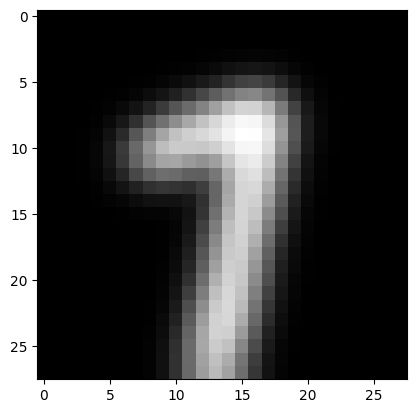

In [14]:
noise_transform_2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.GaussianBlur(11)
])

train_noise_2 = MNIST('.', train=True, transform=noise_transform_2)
plt.imshow(train_noise_2[42][0].reshape(28, 28), cmap=plt.cm.Greys_r)

Соберём все аугментации в один датасет. Для этого сконкатенируем имеющиеся датасеты аугментаций.

In [24]:
from torch.utils.data import ConcatDataset

In [41]:
train_augs = ConcatDataset(datasets=[train_rotate, train_translate, train_noise])

#### Демонстрация аугментаций

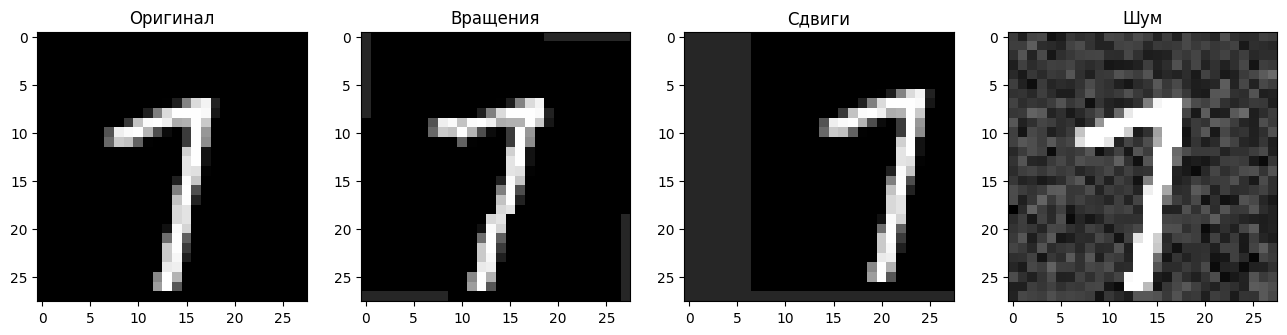

In [42]:
i=42
n=4

plt.figure(figsize=(16, 6))

plt.subplot(1, n, 1)
plt.title('Оригинал')
plt.imshow(train_dataset[i][0].reshape(28, 28), cmap=plt.cm.Greys_r)

plt.subplot(1, n, 2)
plt.title('Вращения')
plt.imshow(train_rotate[i][0].reshape(28, 28), cmap=plt.cm.Greys_r)

plt.subplot(1, n, 3)
plt.title('Сдвиги')
plt.imshow(train_translate[i][0].reshape(28, 28), cmap=plt.cm.Greys_r)

plt.subplot(1, n, 4)
plt.title('Шум')
plt.imshow(train_noise[i][0].reshape(28, 28), cmap=plt.cm.Greys_r)

plt.show()

#### Влияние аугментаций на модель

Давайте обучим сеть, на следующих наборах данных:
* Оригинал + Случайный поворот
* Оригинал + Случайный сдвиг
* Оригинал + Шум
* Оригинал + Все аугментации

In [27]:
train_loader = DataLoader(
    ConcatDataset(datasets=[train_dataset, train_rotate]), 
    batch_size=32, 
    shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Epoch 19... (Train/Test) NLL: 0.032/0.060	Accuracy: 0.991/0.982

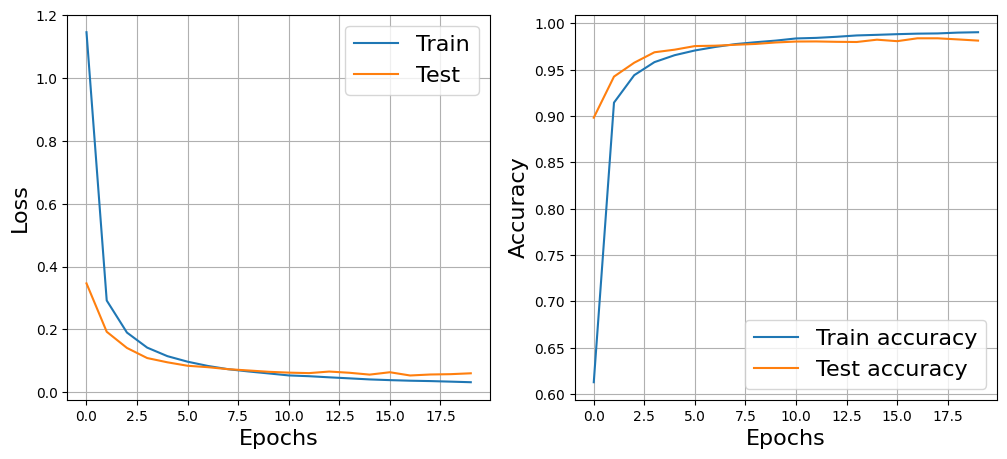

In [29]:
network_rot = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])

tr_rot, ts_rot, tr_ac_rot, ts_ac_rot = train(network_rot, 20, 0.01)

Google colab : 36 min

In [30]:
train_loader = DataLoader(
    ConcatDataset(datasets=[train_dataset, train_translate]), 
    batch_size=32, 
    shuffle=True
)

Epoch 19... (Train/Test) NLL: 0.167/0.093	Accuracy: 0.947/0.970

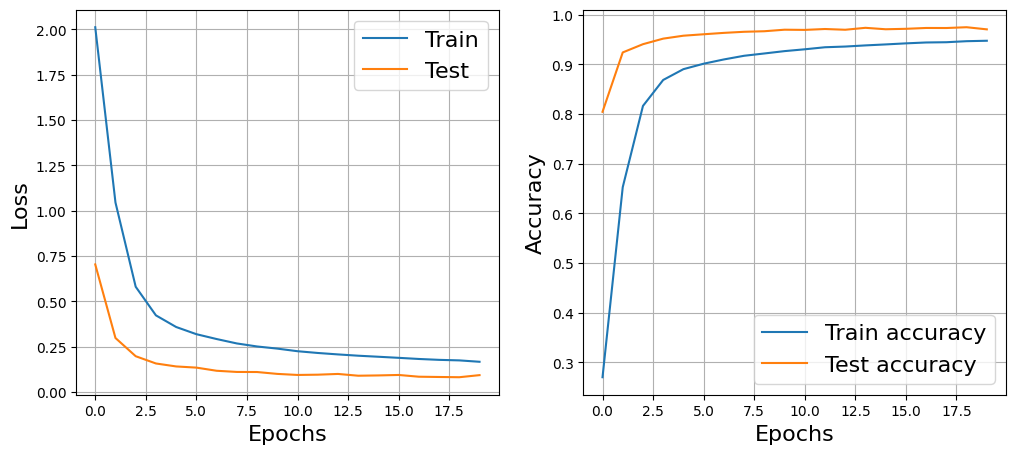

In [31]:
network_trn = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])

tr_trn, ts_trn, tr_ac_trn, ts_ac_trn = train(network_trn, 20, 0.01)

Google colab : 38 min

In [43]:
train_loader = DataLoader(
    ConcatDataset(datasets=[train_dataset, train_noise]), 
    batch_size=32, 
    shuffle=True
)

Epoch 19... (Train/Test) NLL: 0.017/0.099	Accuracy: 0.996/0.978

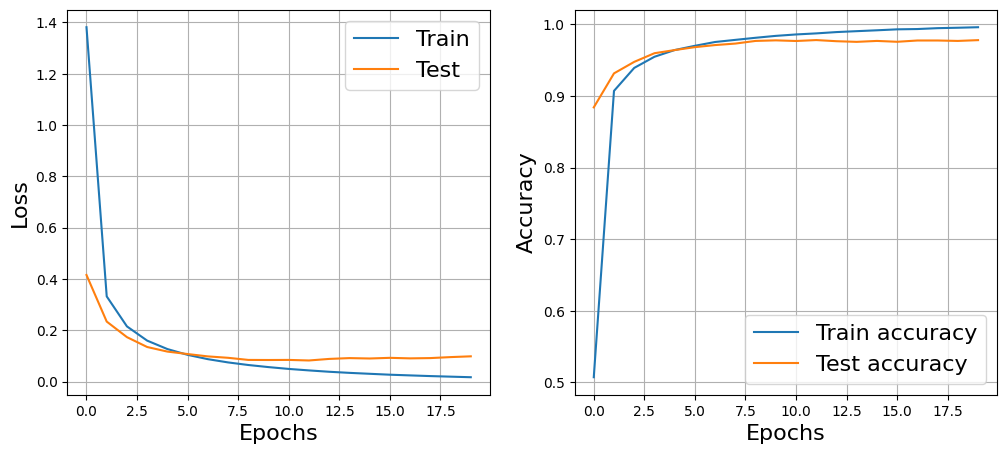

In [44]:
network_noi = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])

tr_noi, ts_noi, tr_ac_noi, ts_ac_noi = train(network_noi, 20, 0.01)

Google colab : 30 min

In [45]:
train_loader = DataLoader(
    ConcatDataset(datasets=[train_dataset, train_augs]), 
    batch_size=32, 
    shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Epoch 19... (Train/Test) NLL: 0.098/0.053	Accuracy: 0.970/0.984

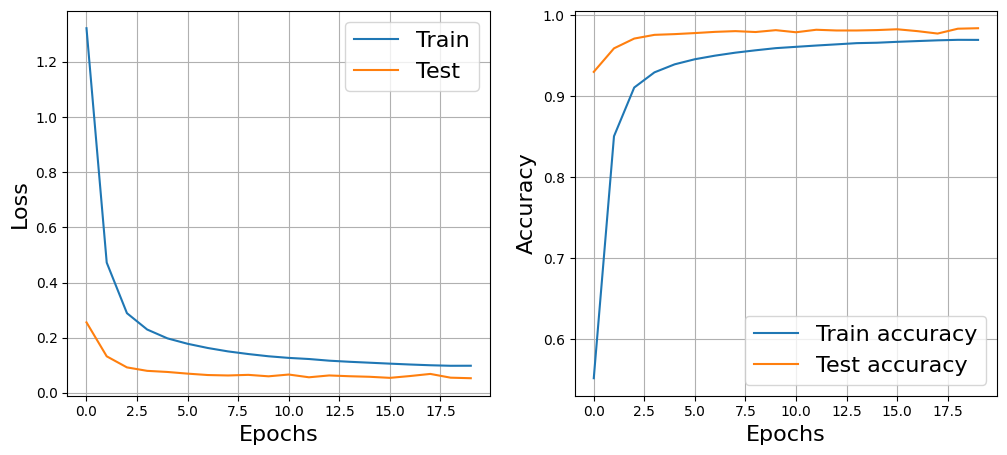

In [46]:
network_all = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])

tr_all, ts_all, tr_ac_all, ts_ac_all = train(network_all, 20, 0.01)

Google colab : 1 h

#### Сравнительные графики 

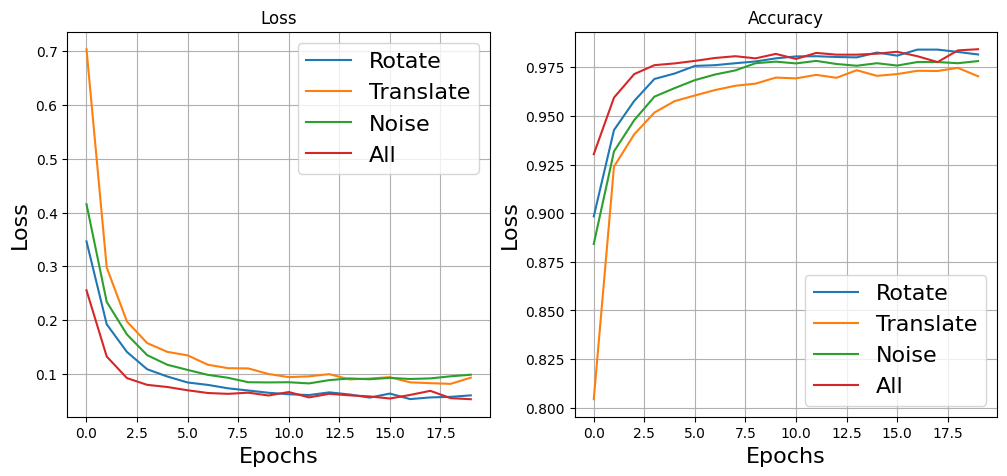

In [47]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_rot, label='Rotate')
plt.plot(ts_trn, label='Translate')
plt.plot(ts_noi, label='Noise')
plt.plot(ts_all, label='All')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_rot, label='Rotate')
plt.plot(ts_ac_trn, label='Translate')
plt.plot(ts_ac_noi, label='Noise')
plt.plot(ts_ac_all, label='All')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.show()

#### Выводы по аугментациям

Топ аугментаций по отдельности:
1. Поворот от -15° до 15° : 36 минут
2. Шум со стандартными параметрами : 30 минут
3. Случайный сдвиг : 38 минут

Использование всех аугментаций сразу, увеличивает сходимость по эпохам, что логично т.к. увеличено общее количество сэмплов. В дальнейшем использование только поворота, сравнивается с использованием всей пачки аугментаций из чего можно сделать следующий вывод: <br>

**Для расширения датасета MNIST эффиктивнее использовать среди всех аугментаций - поворот, при условии что у нас более 7 эпох, иначе целесообразнее использовать все аугментации, чтобы быстрее сойтись**.

Такие хорошие результаты поворота вполне возможно коррелируют с тем, что некоторые изображения порой вовсе не поворачиваются или совсем немного в пределах [-15°, 15°].